# Netflix 데이터 분석
### 데이터 수집
- flixpatrol 사이트에서 데이터 수집
    - `https://flixpatrol.com/top10/netflix/world/2021/full/#netflix-1`


- kaggle에서 netflix 컨텐츠 데이터 수집
    - `https://www.kaggle.com/shivamb/netflix-shows`


- 컨텐츠의 등급데이터는 아래의 코드 사용
```
ratings_ages = {'TV-PG': 'Older Kids', 'TV-MA': 'Adults', 'TV-Y7-FV': 'Older Kids',
                  'TV-Y7': 'Older Kids', 'TV-14': 'Teens', 'R': 'Adults', 'TV-Y': 'Kids',
                  'NR': 'Adults', 'PG-13': 'Teens', 'TV-G': 'Kids', 'PG': 'Older Kids',
                  'G': 'Kids', 'UR': 'Adults', 'NC-17': 'Adults'}
```

# flixpatrol 사이트

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
year=2021
url = f"https://flixpatrol.com/top10/netflix/world/{year}/full/"
response = requests.get(url)
dom = BeautifulSoup(response.text, "html.parser")

### TOP MOVIE

In [47]:
elements = dom.select("#netflix-1 > div.-mx-content > div > div > table > tbody > tr")

datas = []
for element in elements:
        datas.append({
            "title": element.select("td")[2].text.strip(),
            "points": element.select("td")[3].text,
            "countries": element.select("td")[5].text,
            "days": element.select("td")[7].text,
        })
Top_movie = pd.DataFrame(datas)
Top_movie.tail(2)

,title,points,countries,days
174,Bombshell,181,2,14
175,Man on a Ledge,174,4,13


In [48]:
# csv파일로 저장
Top_movie(2021).to_csv('top_movie.csv', index=False)

### TOP TV

In [49]:
elements = dom.select("#netflix-2 > div.-mx-content > div > div > table > tbody > tr")

datas = []
for element in elements:
        datas.append({
            "title": element.select("td")[2].text.strip(),
            "points": element.select("td")[3].text,
            "countries": element.select("td")[5].text,
            "days": element.select("td")[7].text,
        })
Top_tv = pd.DataFrame(datas)
Top_tv.tail(2)

,title,points,countries,days
150,Beauty and the Baker,"1,638",18,28
151,Zero Chill,"1,631",49,20


## kaggle에서 netflix 컨텐츠 데이터 수집

### 1. 데이터불러오기

In [14]:
!pip install missingno

In [15]:
%config InlineBackend.figure_formats = {'png', 'retina'}
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [10]:
netfilx = pd.read_csv("netflix_titles.csv")
netfilx.tail(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [11]:
netfilx['rating'] = netfilx['rating'].map({'TV-PG': 'Older Kids', 'TV-MA': 'Adults', 'TV-Y7-FV': 'Older Kids',
                'TV-Y7': 'Older Kids', 'TV-14': 'Teens', 'R': 'Adults', 'TV-Y': 'Kids',
                'NR': 'Adults', 'PG-13': 'Teens', 'TV-G': 'Kids', 'PG': 'Older Kids',
                'G': 'Kids', 'UR': 'Adults', 'NC-17': 'Adults'})
netfilx.tail(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,Older Kids,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,Teens,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


### 2. 결측치 확인 및 제거

In [12]:
netfilx.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             7
duration           3
listed_in          0
description        0
dtype: int64

> director, cast, country, date_added, rating 결측데이터 확인

--------------------------

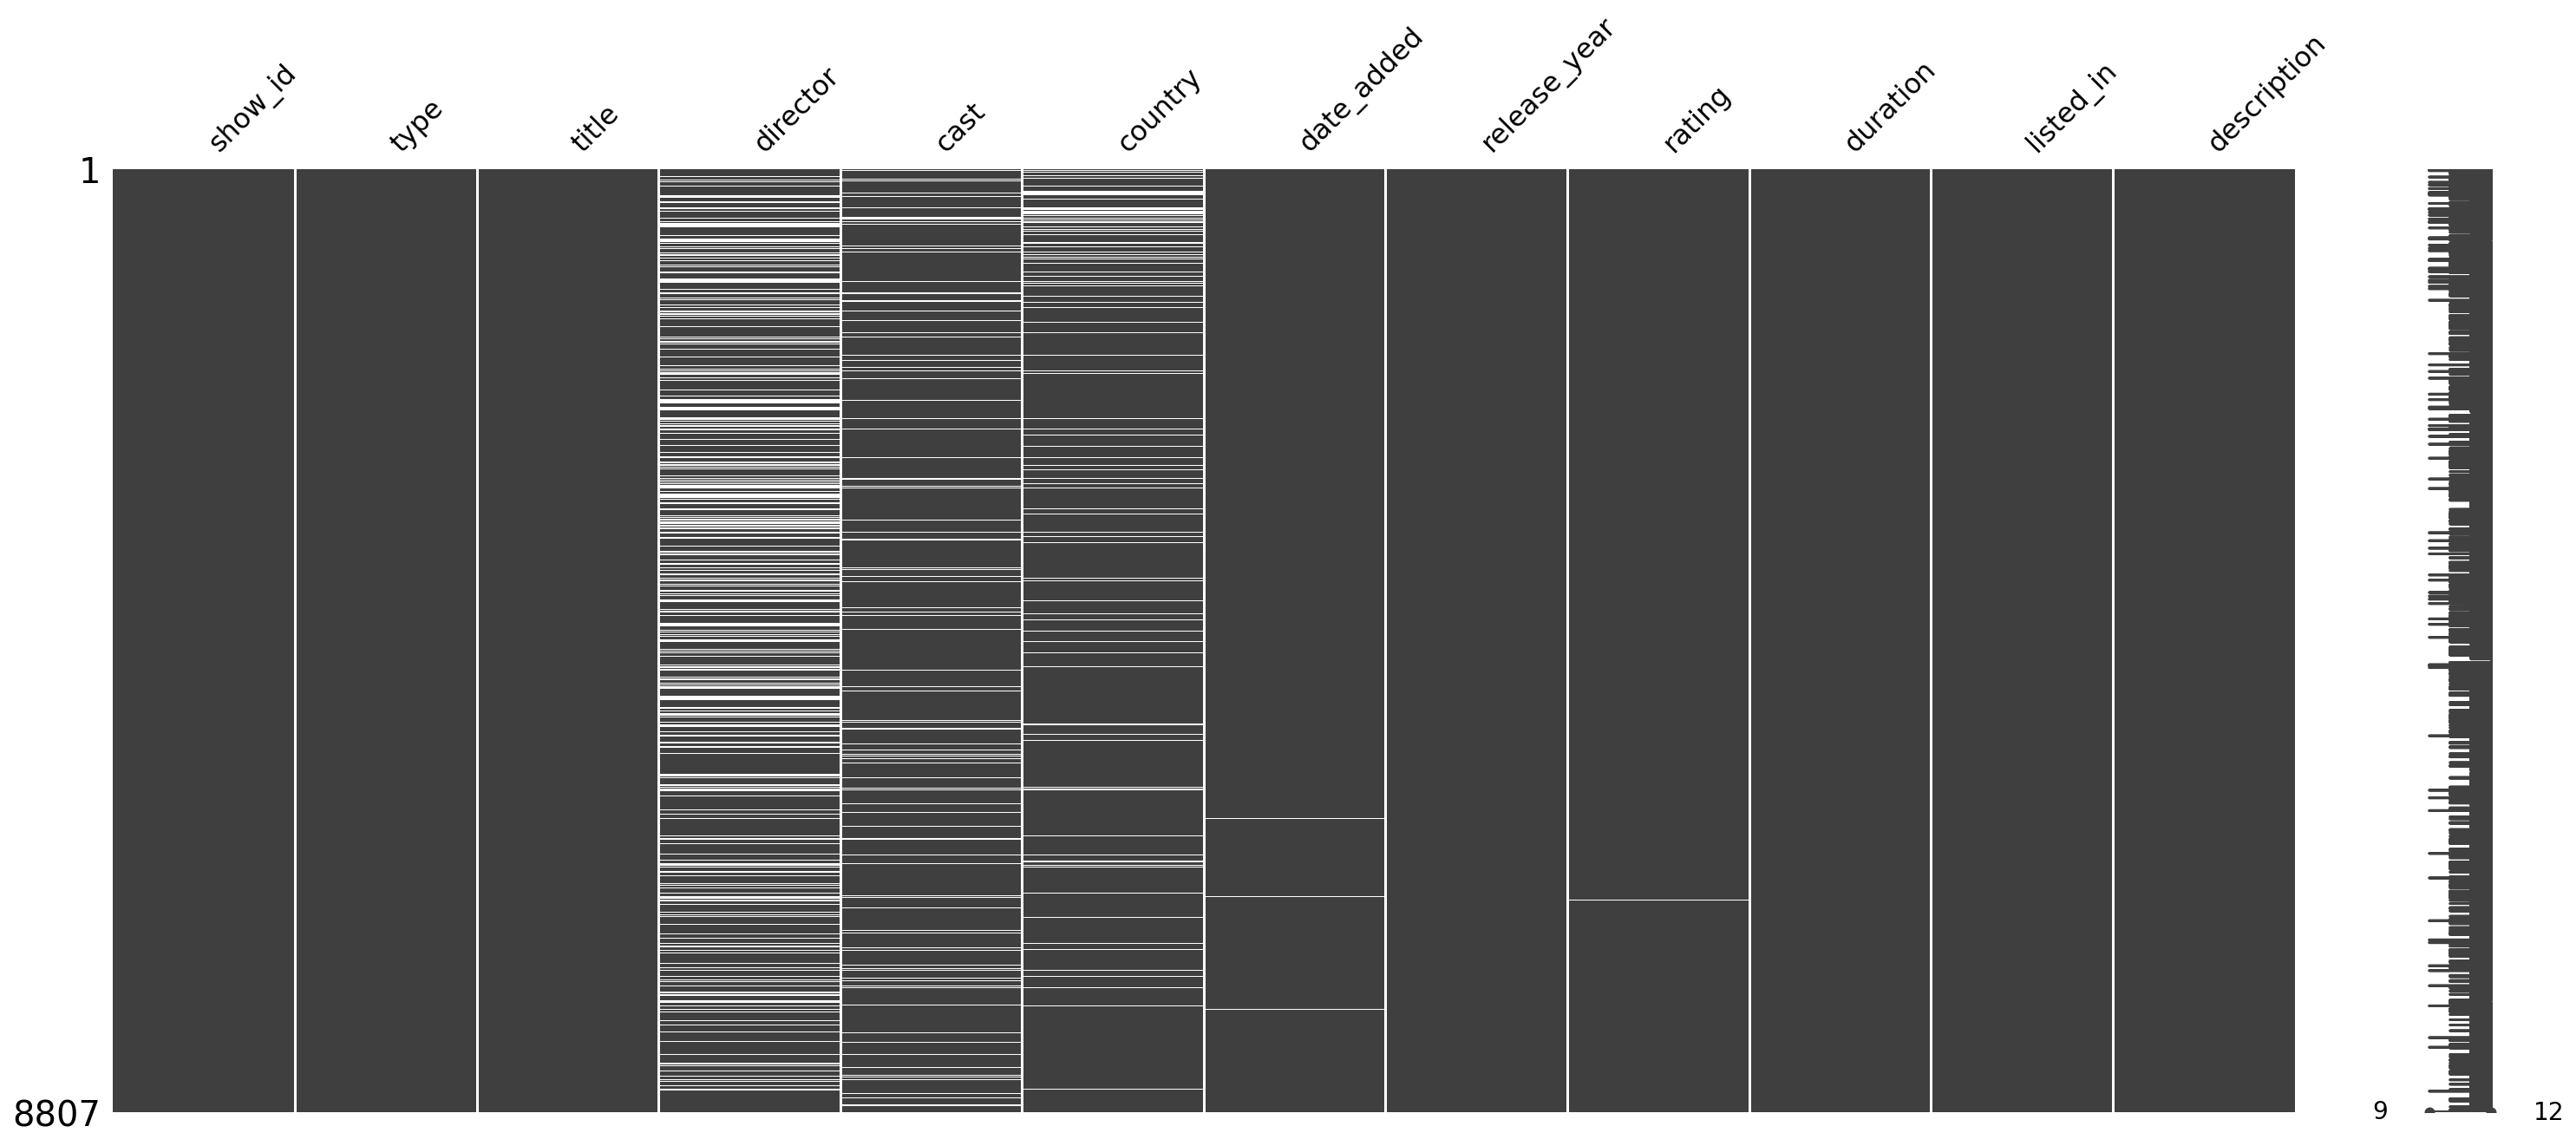

In [17]:
msno.matrix(netfilx)
plt.show()

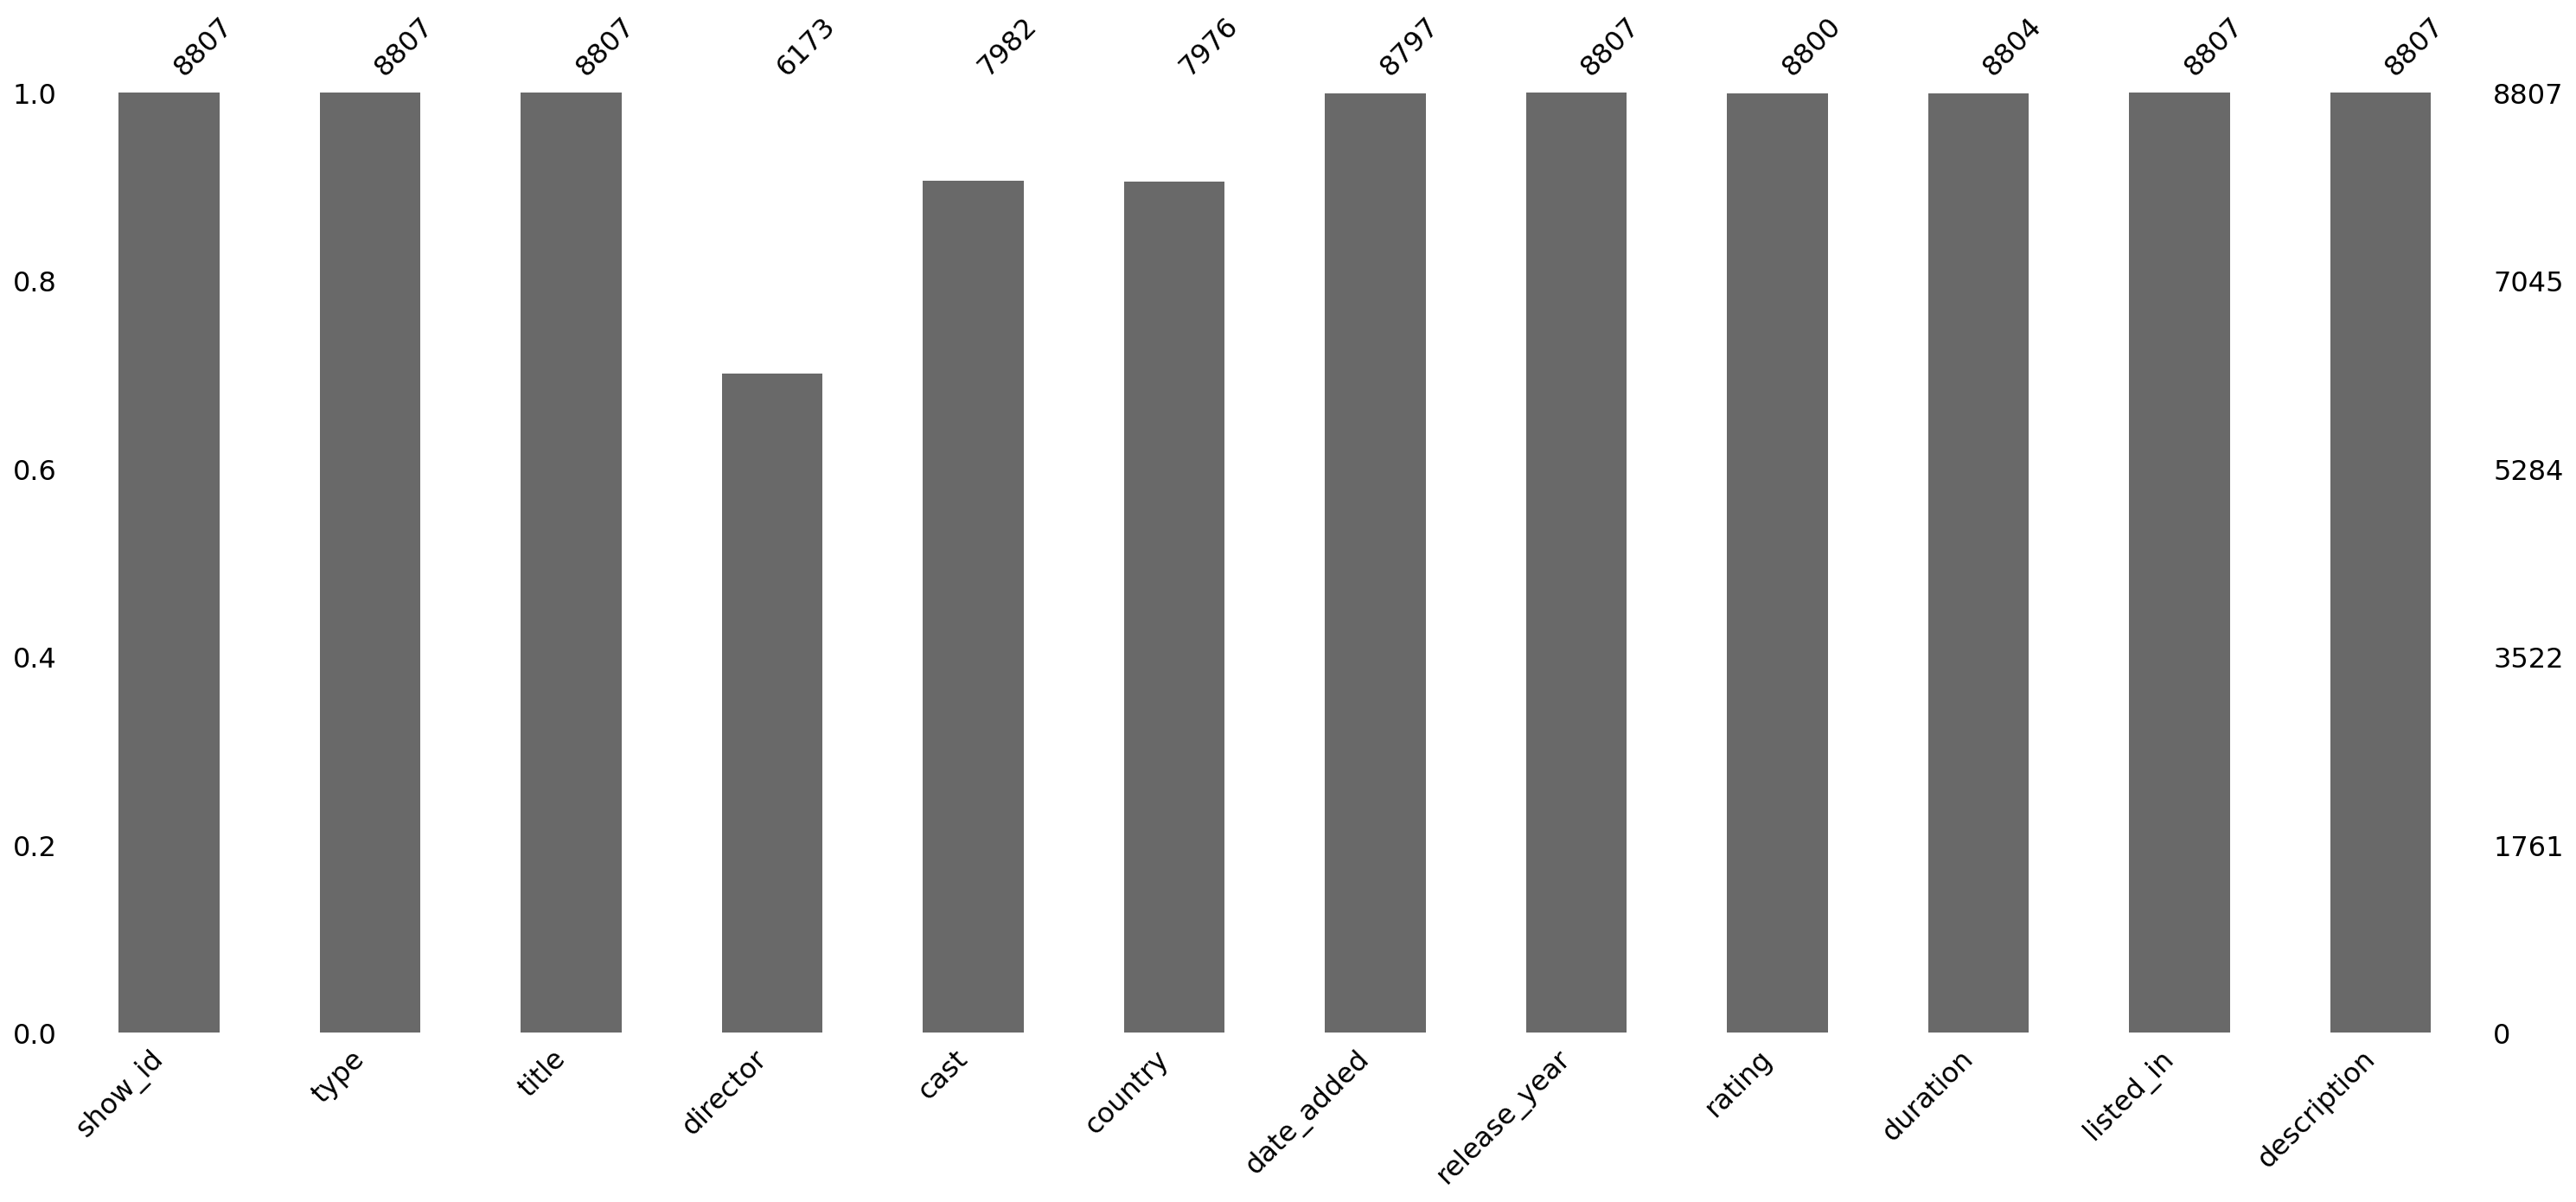

In [18]:
msno.bar(netfilx)
plt.show()

> 불필요한 컬럼 제거(데이터의 80이상 데이터만 사용한다)

In [19]:
rate = 0.8
int(len(netfilx) * rate)

7045

#### 80이하인 director 컬럼은 삭제

In [20]:
filtered_net = netfilx.dropna(thresh=int(len(netfilx) * rate), axis=1)

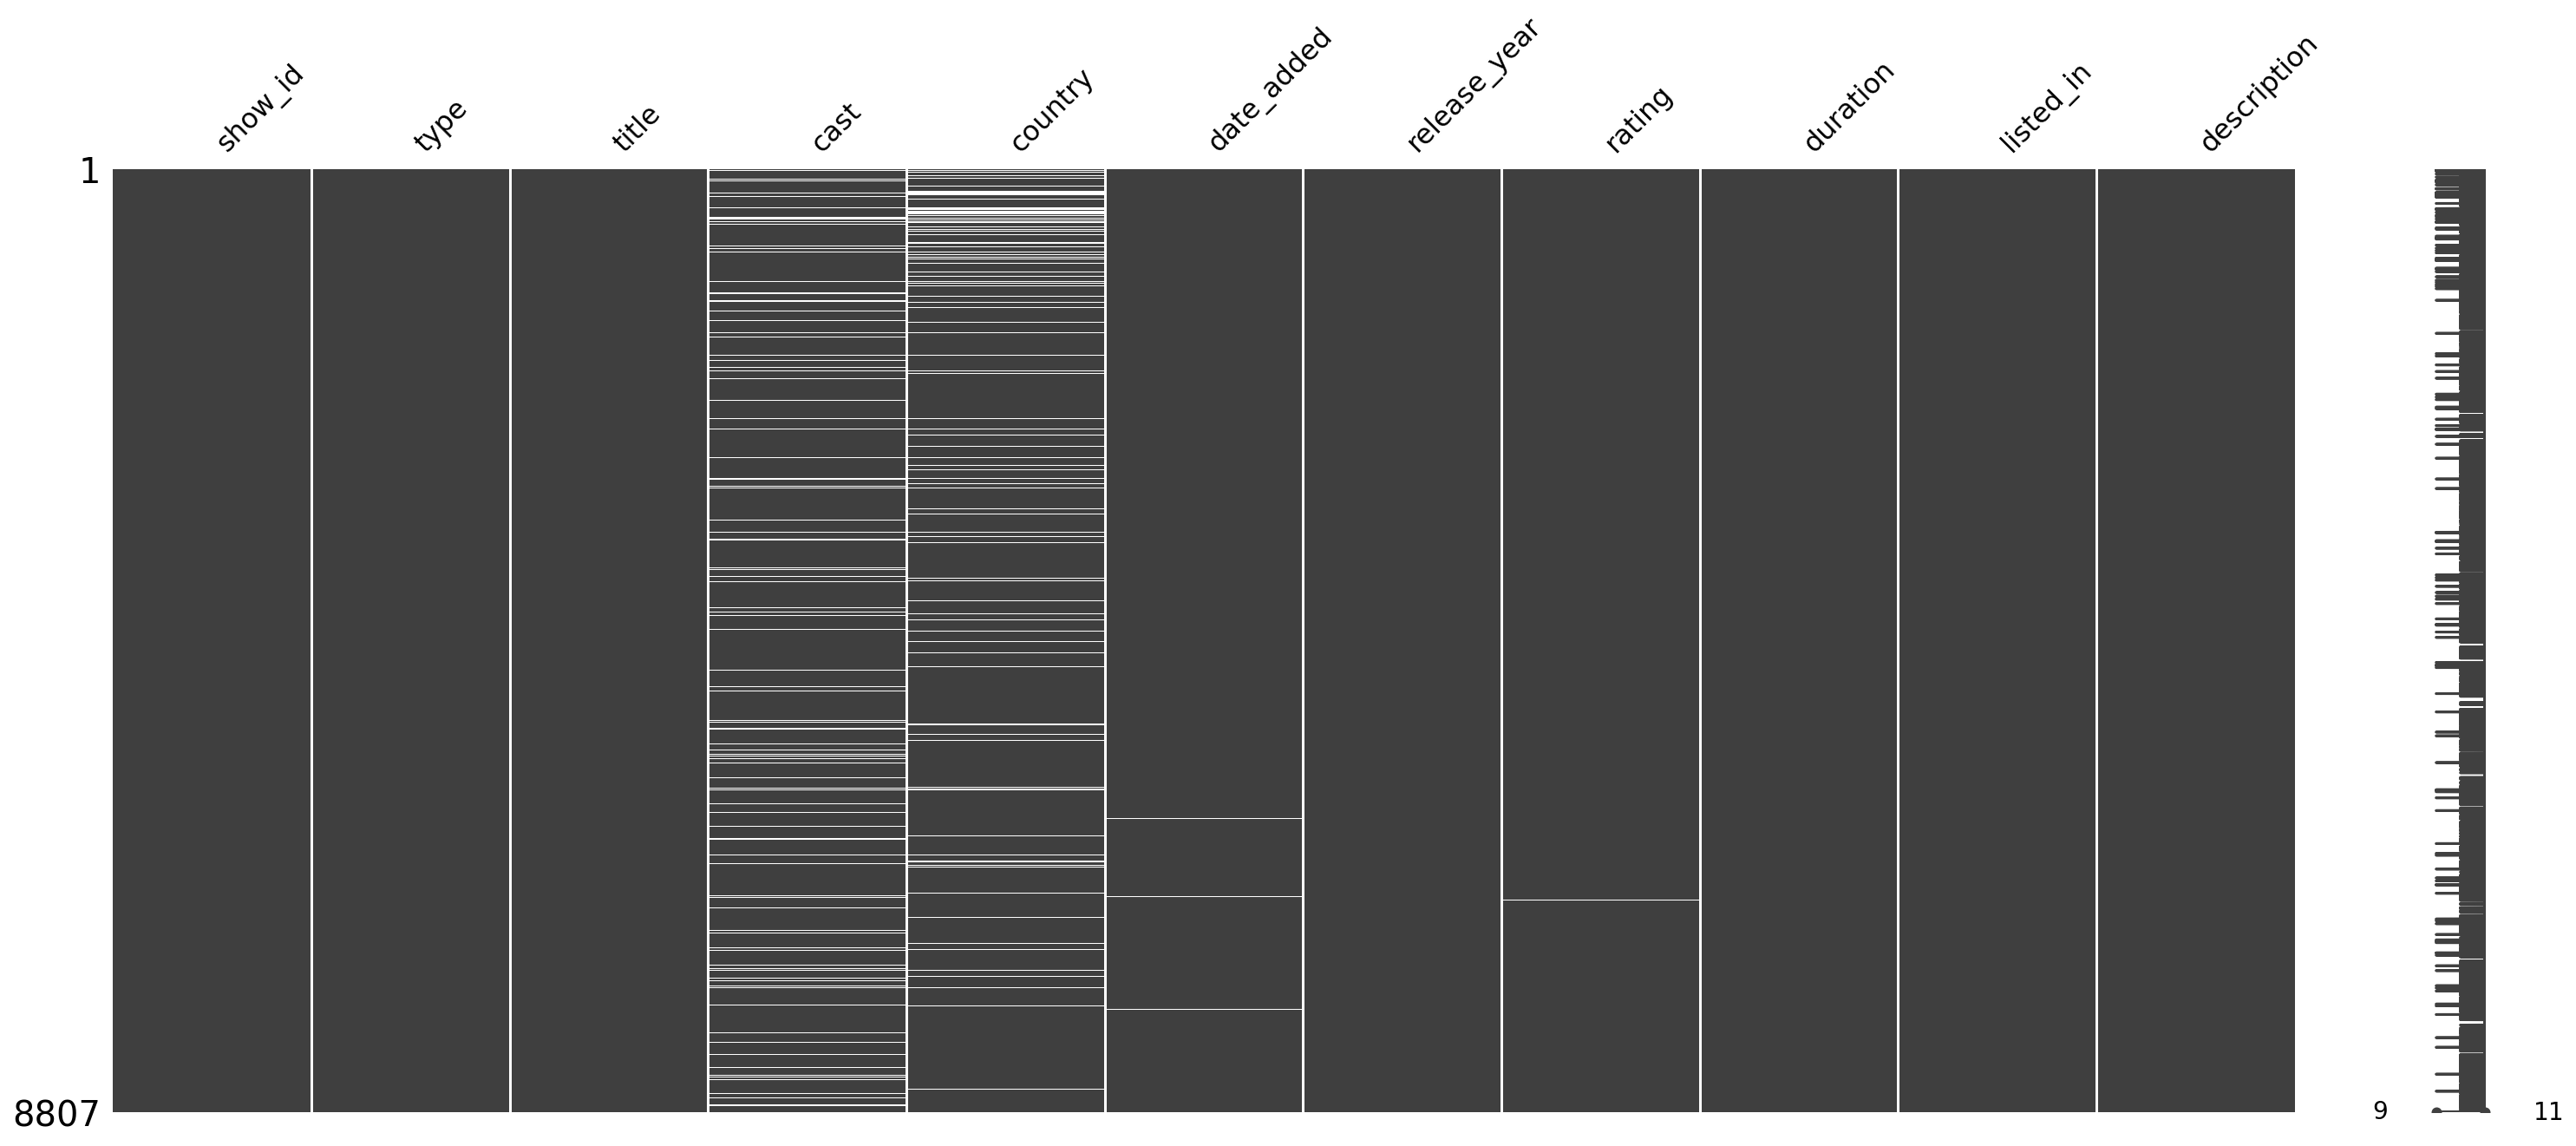

In [21]:
msno.matrix(filtered_net)
plt.show()

> 비어있는 데이터 처리 : 최빈값

In [22]:
filtered_net["rating"][:3]

0     Teens
1    Adults
2    Adults
Name: rating, dtype: object

In [23]:
filtered_net["rating"].value_counts()

Adults        4092
Teens         2650
Older Kids    1490
Kids           568
Name: rating, dtype: int64

In [24]:
from sklearn.impute import SimpleImputer

In [25]:
# 최빈값으로 결측치 채워줌
imputer = SimpleImputer(strategy="most_frequent")

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
filtered_net["rating"] = imputer.fit_transform(filtered_net[["rating"]])

In [51]:
filtered_net["date_added"] = imputer.fit_transform(filtered_net[["date_added"]])
filtered_net["duration"] = imputer.fit_transform(filtered_net[["duration"]])

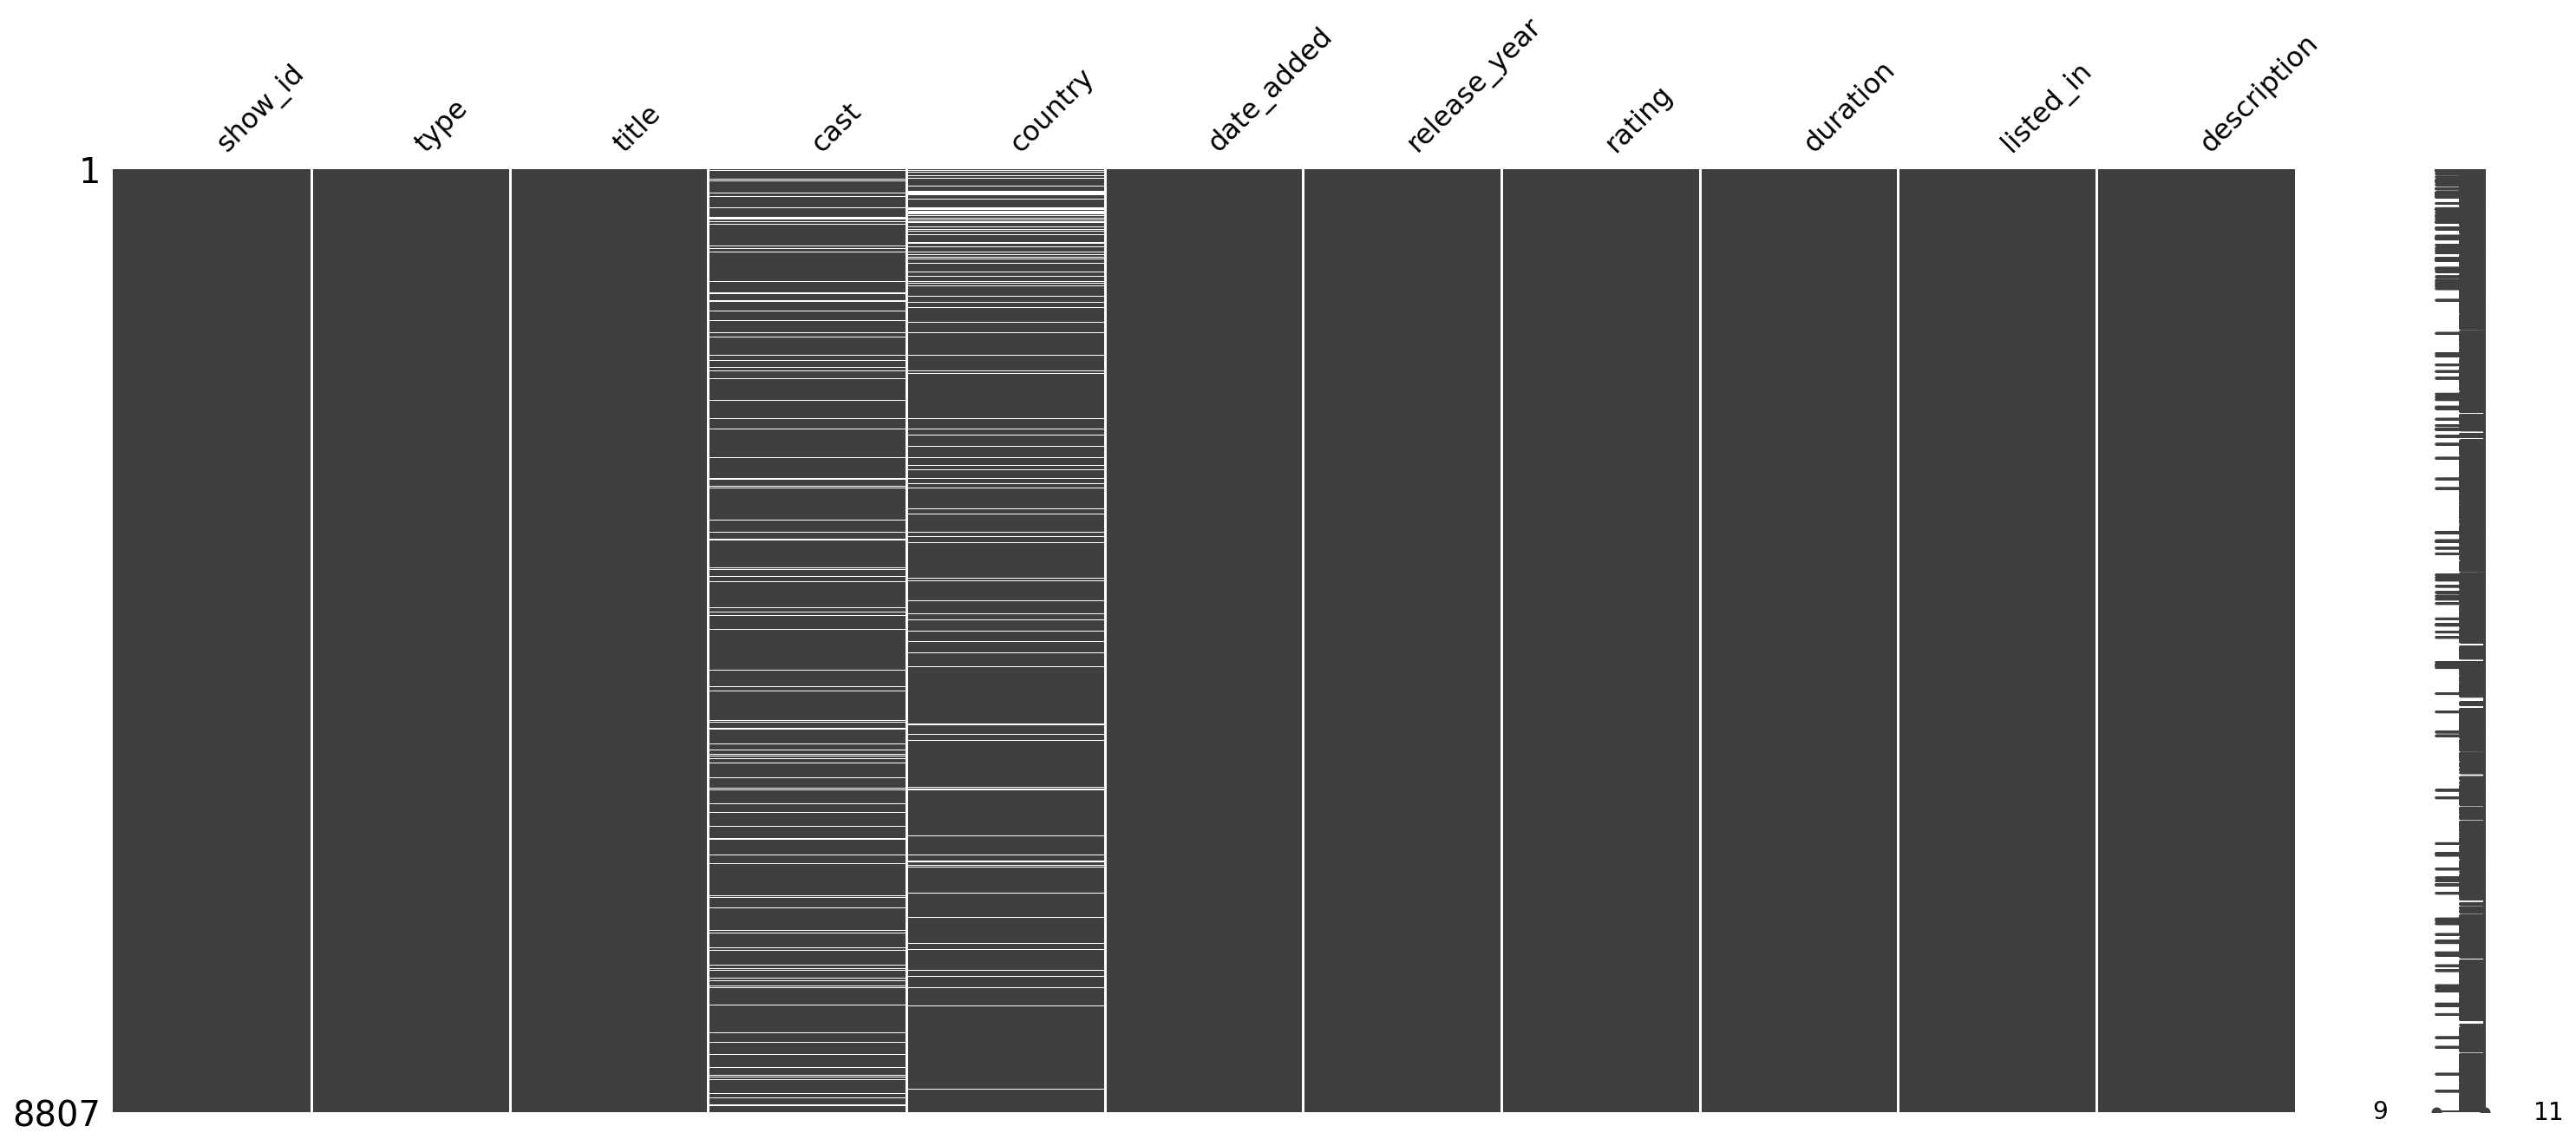

In [52]:
msno.matrix(filtered_net)
plt.show()

In [53]:
filtered_net.isna().sum()

show_id           0
type              0
title             0
cast            825
country         831
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
dtype: int64

------------------

## 3. 데이터전처리

전체 : net_flix  , movie : net_movie, tv : net_tv

In [61]:
net_flix = filtered_net.copy()
net_flix.tail(5)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
8802,s8803,Movie,Zodiac,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,Adults,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,"July 1, 2019",2018,Older Kids,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,Adults,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,Older Kids,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,Teens,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [78]:
net_flix = net_flix.dropna()

In [79]:
net_movie = net_flix.loc[net_flix["type"]=="Movie"]
net_movie.tail(2)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
8805,s8806,Movie,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,Older Kids,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,Teens,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [80]:
net_tv = net_flix.loc[net_flix["type"]=="TV Show"]
net_tv.tail(2)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
8797,s8798,TV Show,Zak Storm,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,Older Kids,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...
8800,s8801,TV Show,Zindagi Gulzar Hai,"Sanam Saeed, Fawad Khan, Ayesha Omer, Mehreen ...",Pakistan,"December 15, 2016",2012,Older Kids,1 Season,"International TV Shows, Romantic TV Shows, TV ...","Strong-willed, middle-class Kashaf and carefre..."


## 4. 데이터 탐색 : EDA

### Movie - Tv 비교

In [81]:
net_type = net_flix["type"].value_counts()
net_type

Movie      5281
TV Show    2024
Name: type, dtype: int64

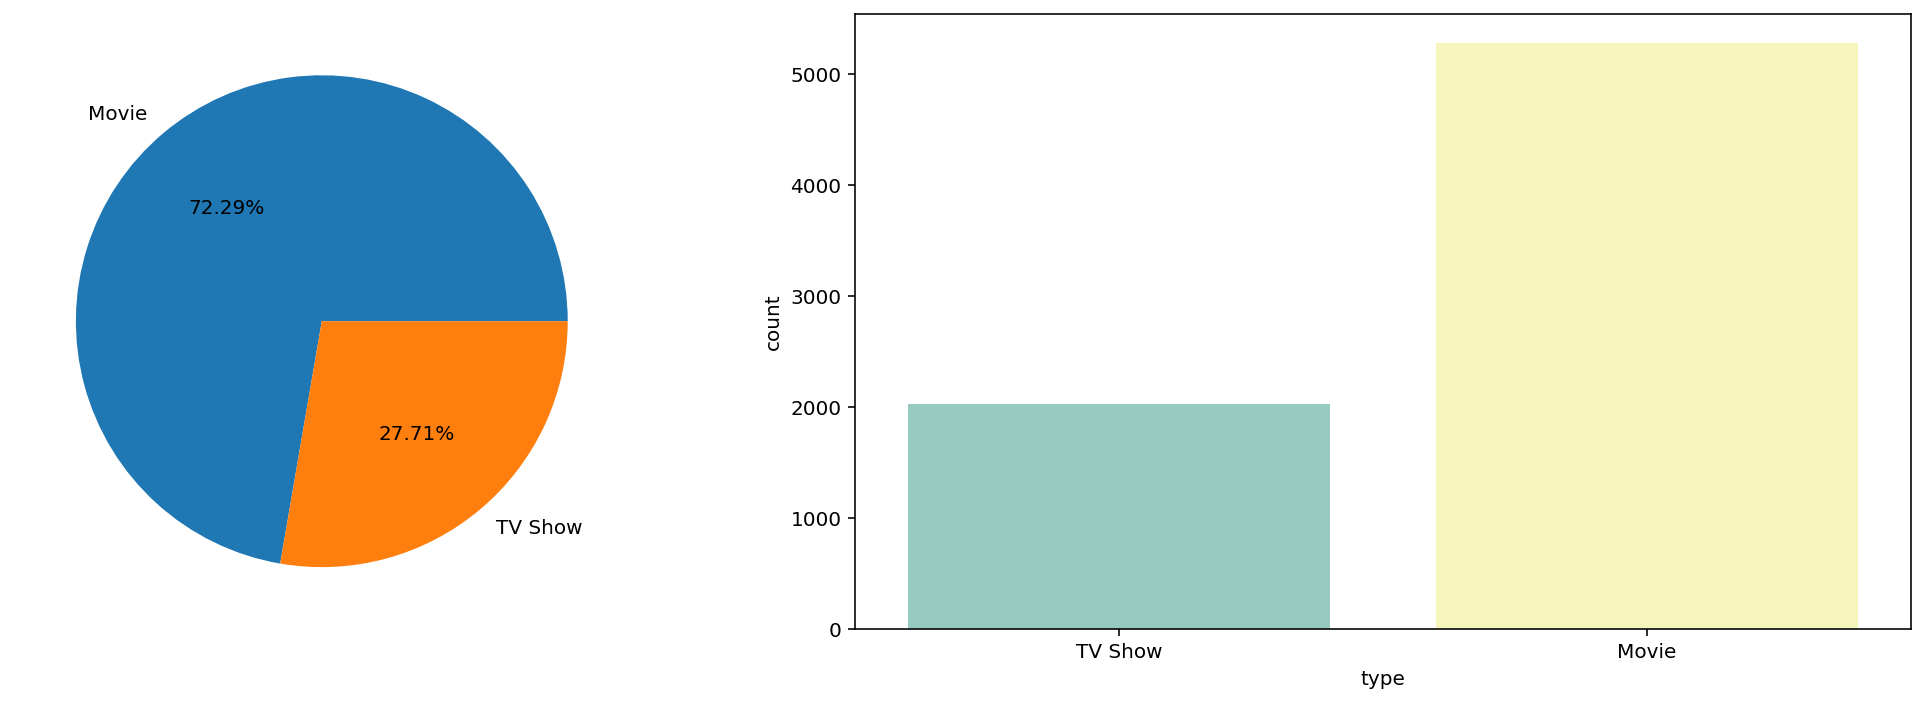

In [82]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.pie(net_type.values, labels=net_type.index, autopct="%1.2f%%")
plt.subplot(1,2,2)
sns.countplot(x="type", data=net_flix, palette="Set3")

plt.tight_layout()
plt.show()

> 영화 타입이 TV타입의 2배이상으로 많다.

## rating

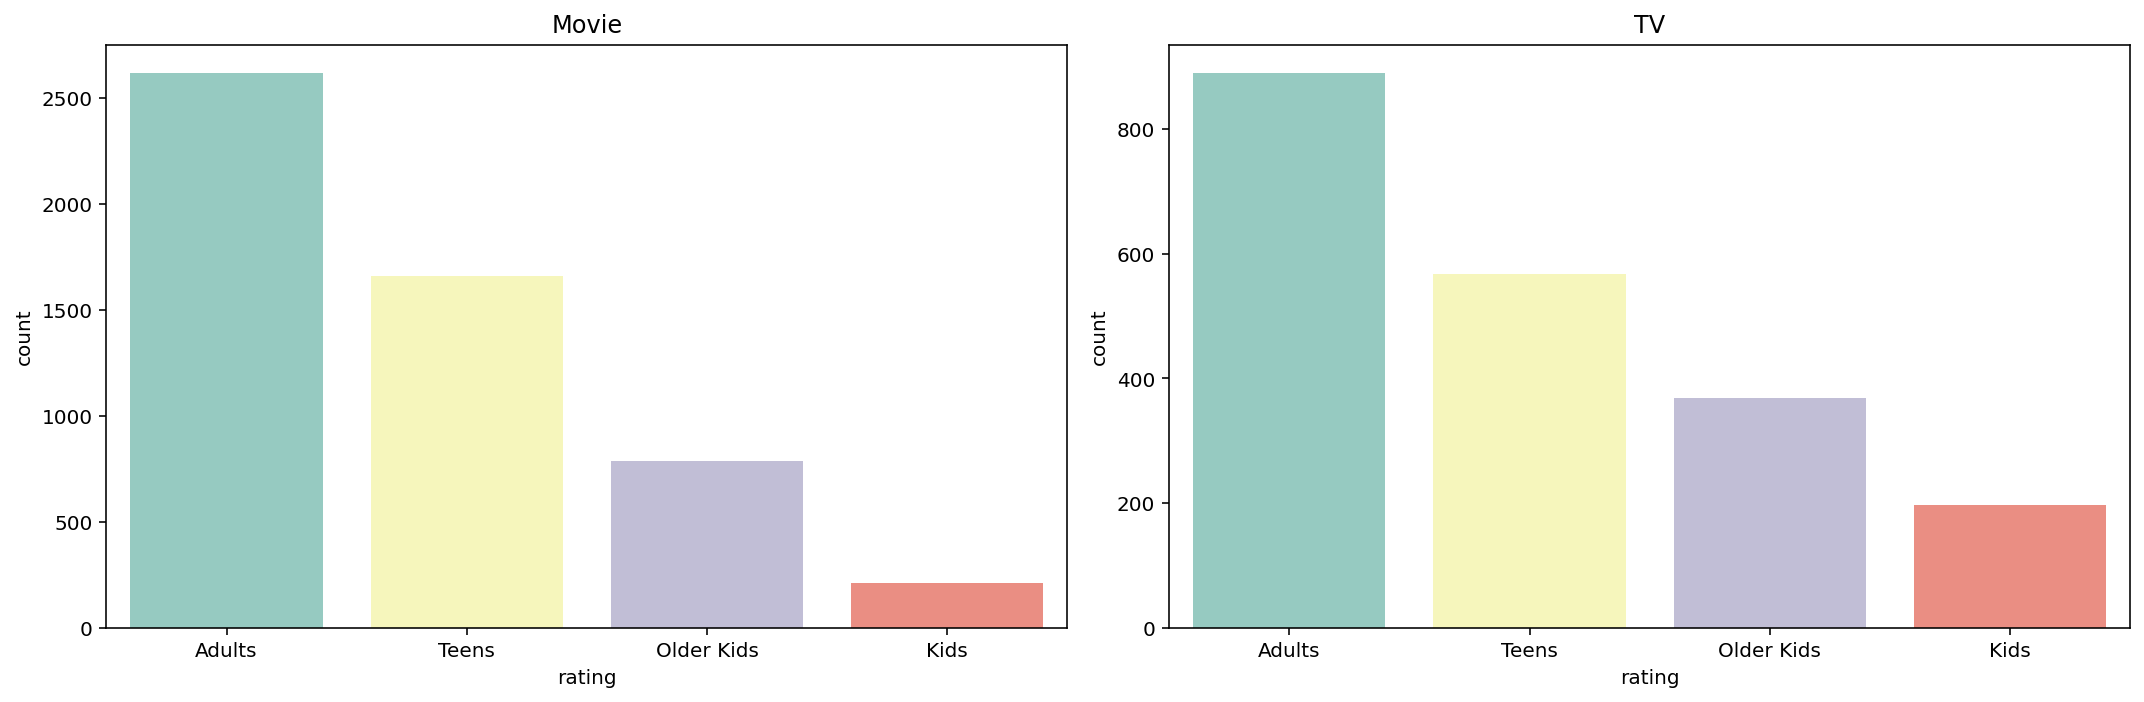

In [83]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Movie")
sns.countplot(x="rating", data=net_movie, palette="Set3")

plt.subplot(1,2,2)
plt.title("TV")
sns.countplot(x="rating", data=net_tv, palette="Set3")

plt.tight_layout()
plt.show()

In [84]:
age_movie = net_movie["rating"].value_counts()
age_tv = net_tv["rating"].value_counts()

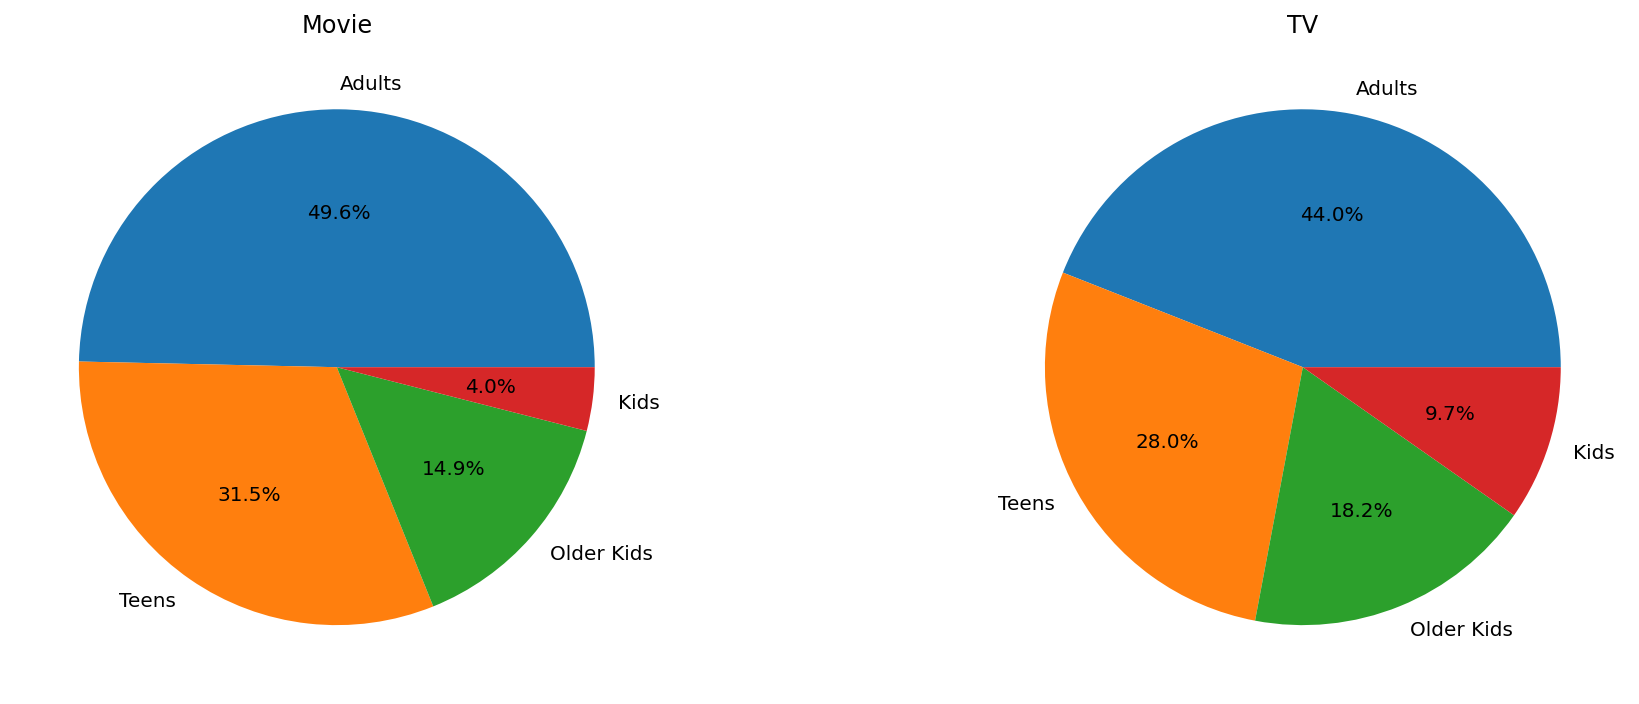

In [85]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Movie")
plt.pie(age_movie.values, labels=age_movie.index, autopct="%1.1f%%")

plt.subplot(1,2,2)
plt.title("TV")
plt.pie(age_tv.values, labels=age_tv.index, autopct="%1.1f%%")

plt.tight_layout()
plt.show()

> 영화가 tv쇼보다 청소년 관람불가 등급 비율이 더 높고 tv가 영화보다 kids 관련 등급의 컨텐츠 비율이 더 높다

## country(국가별 컨텐츠 제작수)

* 상위 10개 국가

In [90]:
country_df = net_flix["country"].value_counts()
country_df = country_df.reset_index()[:10]
country_df = country_df.rename(columns={"index":"country","country":"count"})
country_df

,country,count
0,United States,2488
1,India,940
2,United Kingdom,351
3,Japan,240
4,South Korea,196
5,Canada,162
6,Spain,127
7,France,106
8,Egypt,105
9,Turkey,105


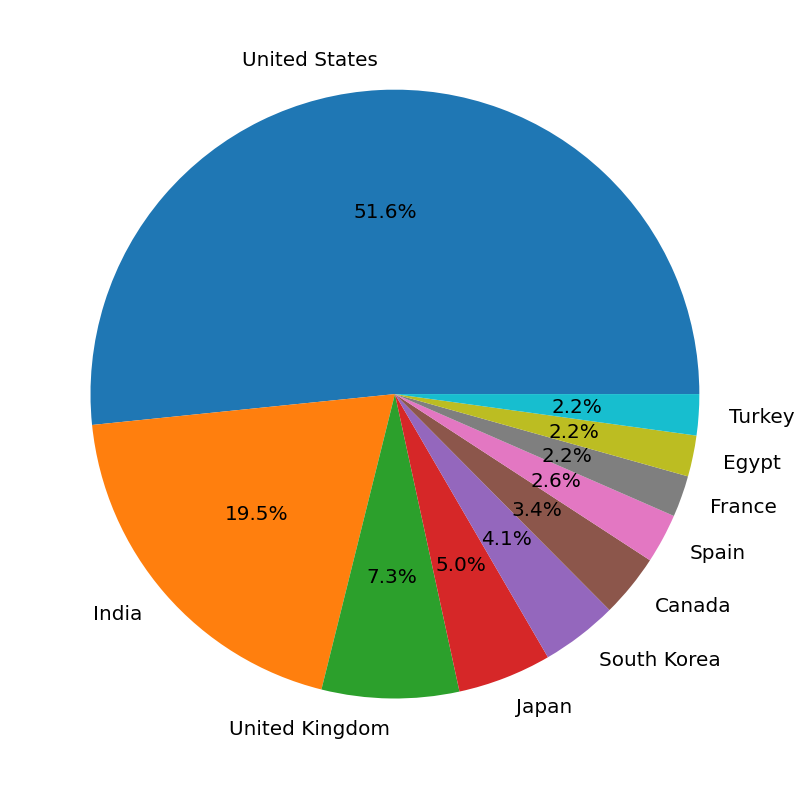

In [92]:
plt.figure(figsize=(7, 7))
plt.pie(country_df["count"].values, labels=country_df["country"].values,autopct="%1.1f%%")
plt.show()

> 국가별 미국, 인도, 영국, 일본, 한국 순으로 컨텐츠수가 많고 미국이 컨텐츠 강국이고 넷플릭스가 미국 서비스이다 보니 미국의 컨텐츠가 가장 많이 서비스 되고 있는것으로 보입니다. 인도도 볼리우드라고 불리우는 영화산업이 뭄바이에서 활발하게 제작되고 있습니다.

In [94]:
net_flix.head(2)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,TV Show,Blood & Water,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,Adults,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
4,s5,TV Show,Kota Factory,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,Adults,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## duration

* 영화 러닝타임

In [145]:
movie_df = net_flix[net_flix["type"] == "Movie"]
movie_df = movie_df.reset_index(drop=True)
movie_df["running_time"] = movie_df["duration"].apply(lambda data: data.split(" ")[0]).astype("int")


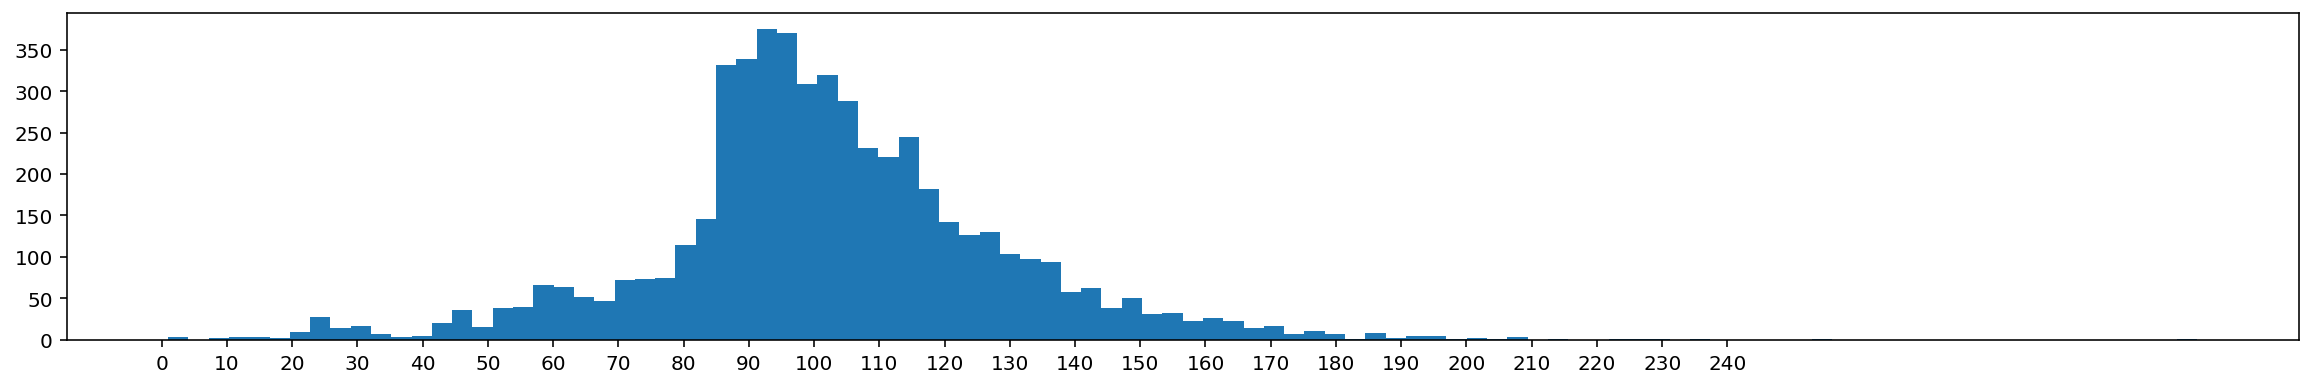

In [144]:
plt.figure(figsize=(20, 3))
plt.hist(movie_df["running_time"], bins=100)
plt.xticks(range(0, 250, 10))
plt.show()

> 영화 러닝타임은 90-110분 사이의 영화가 가장 많다.

* 국가별 러닝타임

In [135]:
# 컨텐츠 제작수 상위 10개 국가
con = country_df["country"].values
con

array(['United States', 'India', 'United Kingdom', 'Japan', 'South Korea',
       'Canada', 'Spain', 'France', 'Egypt', 'Turkey'], dtype=object)

In [147]:
df = movie_df[movie_df["country"].isin(con)]
df.tail(2)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,running_time
5279,s8806,Movie,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,Older Kids,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",88
5280,s8807,Movie,Zubaan,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,Teens,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,111


In [153]:
con_du=df[["country","running_time"]].groupby("country").mean().reset_index()
con_du=con_du.sort_values("running_time",ascending=False)
con_du = np.round(con_du)
con_du

,country,running_time
3,India,128.0
5,South Korea,118.0
1,Egypt,108.0
7,Turkey,107.0
6,Spain,102.0
4,Japan,101.0
2,France,95.0
9,United States,92.0
8,United Kingdom,86.0
0,Canada,83.0


In [158]:
from sklearn.preprocessing import minmax_scale

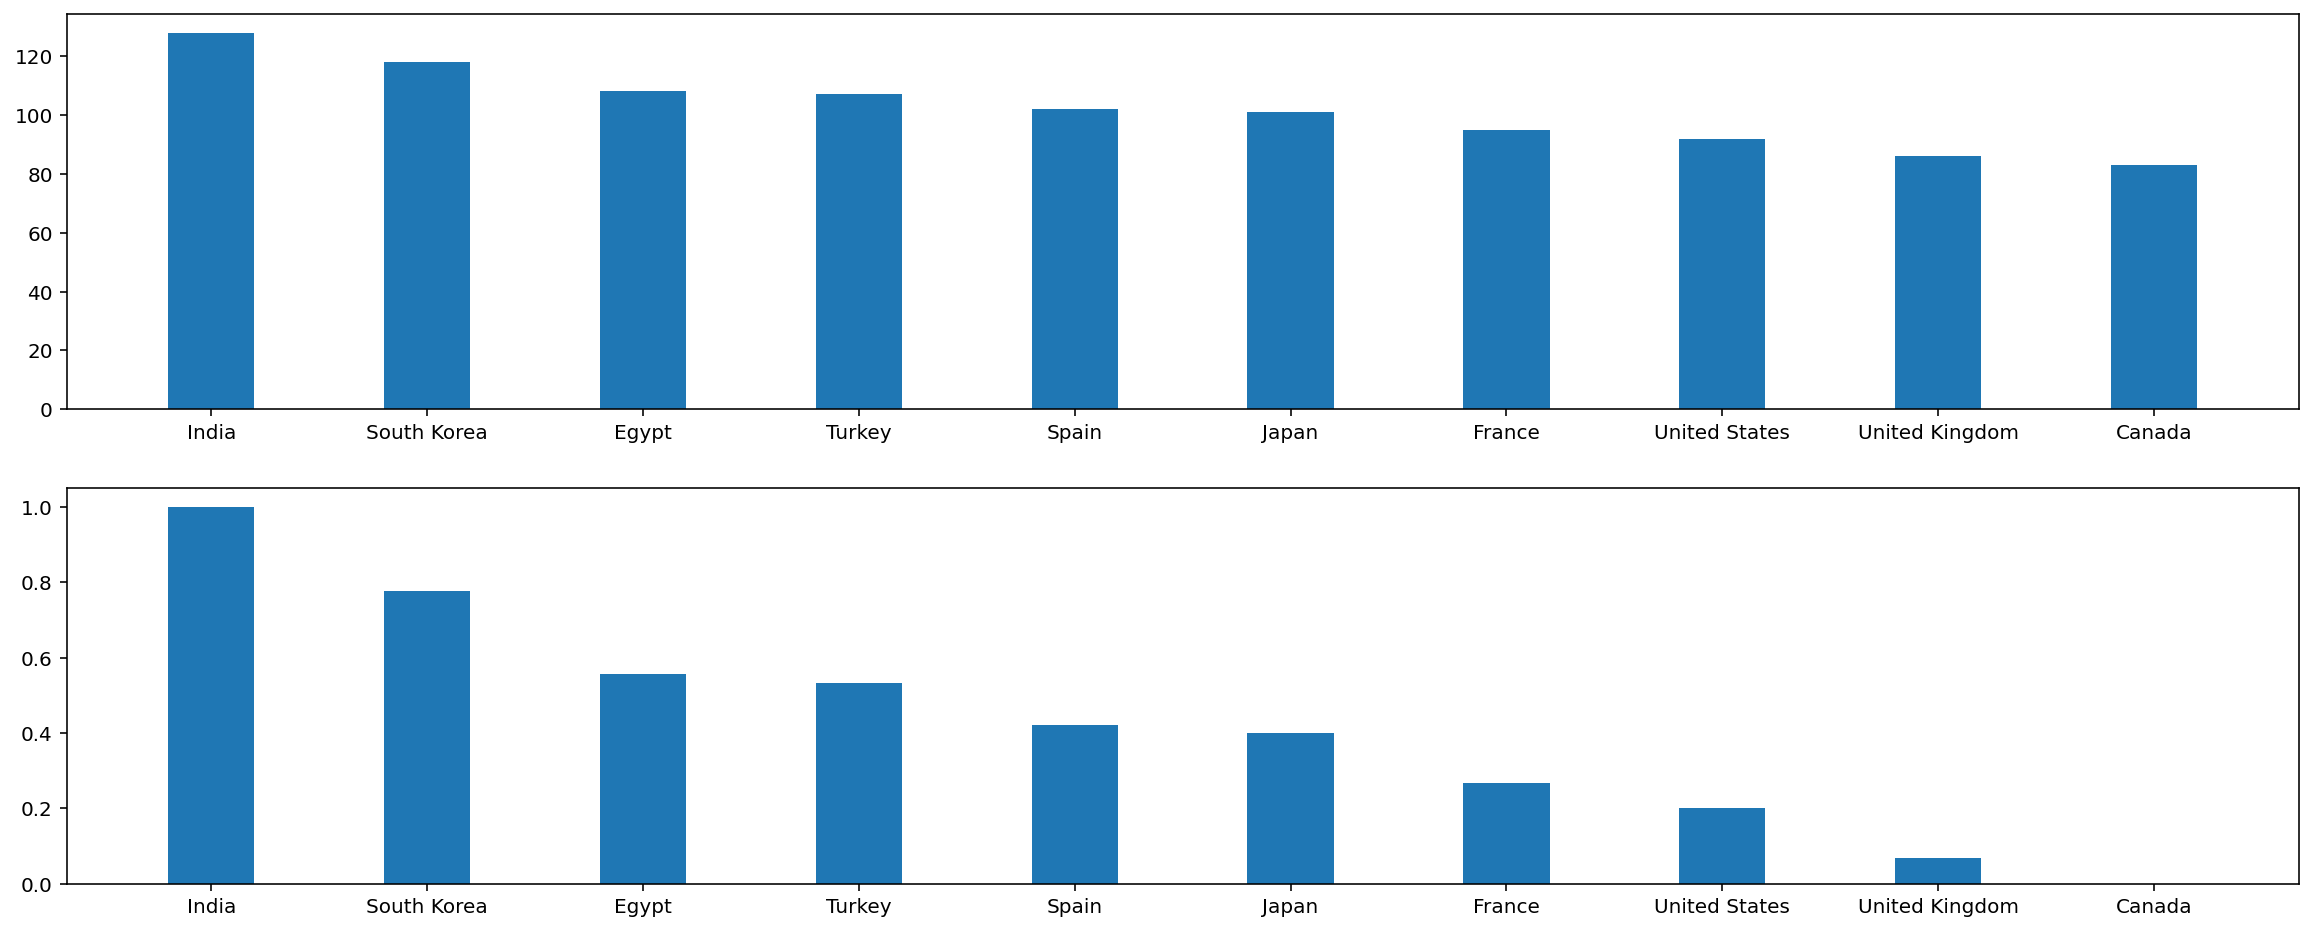

In [159]:
plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.bar(con_du["country"], con_du["running_time"], width=0.4)

# 확연한 차이를 보기위해 스케일링

plt.subplot(2,1,2)
plt.bar(con_du["country"], minmax_scale(con_du["running_time"]), width=0.4)

plt.show()

가설 : 인도의 볼리우드 영화들은 중간중간 뮤지컬적이 요소가 많이 대체로 영화들의 러닝타임이 길기 때문에 인도 영화가 가장 긴 러닝타임을 가질것이다.

> 결론 : 가설대로 인도영화의 러닝타임이 가장 길다.

## 장르

### movie - tv 장르 순위

* 전체 movie 장르

In [180]:
a = net_movie["listed_in"].value_counts().head(10)
a

Dramas, International Movies                        337
Stand-Up Comedy                                     302
Comedies, Dramas, International Movies              260
Dramas, Independent Movies, International Movies    243
Children & Family Movies, Comedies                  181
Documentaries                                       166
Dramas, International Movies, Romantic Movies       161
Comedies, International Movies                      154
Comedies, International Movies, Romantic Movies     144
Children & Family Movies                            141
Name: listed_in, dtype: int64

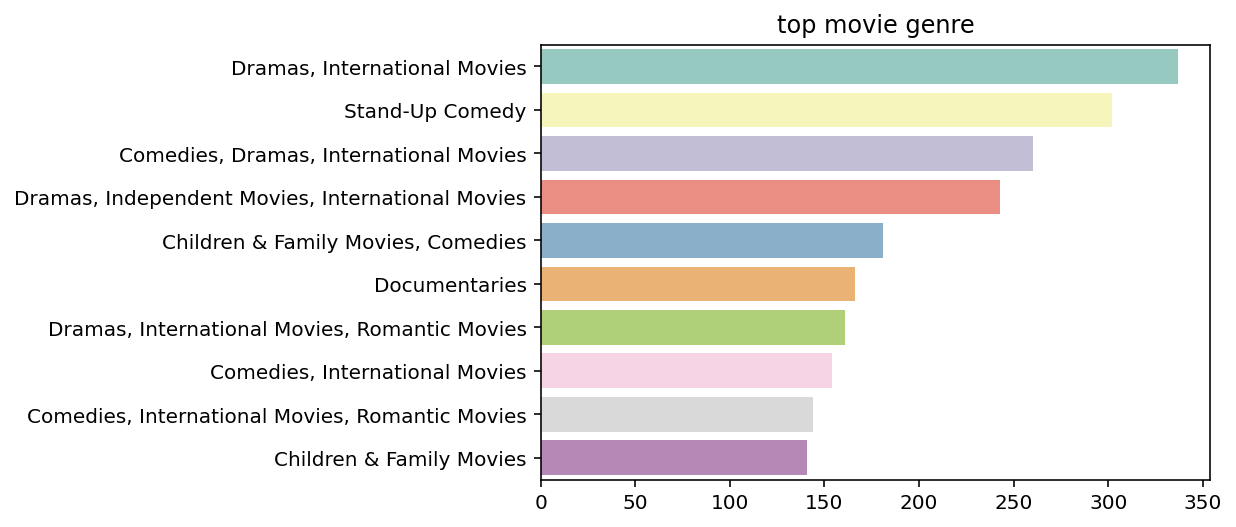

In [183]:
sns.barplot(y = a.index,x=a.values, palette="Set3")
plt.title("top movie genre")
plt.show()

* 한국 movie 장르

In [190]:
k_movie = net_movie.loc[net_movie["country"]=='South Korea']
k_movie.tail(1)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,running_time
8613,s8614,Movie,Train to Busan,"Gong Yoo, Yu-mi Jung, Dong-seok Ma, Soo-an Kim...",South Korea,"March 18, 2017",2016,Adults,118 min,"Action & Adventure, Horror Movies, Internation...","As a zombie outbreak sweeps the country, a dad...",NaN


In [191]:
k_movie=k_movie["listed_in"].value_counts().head(10)

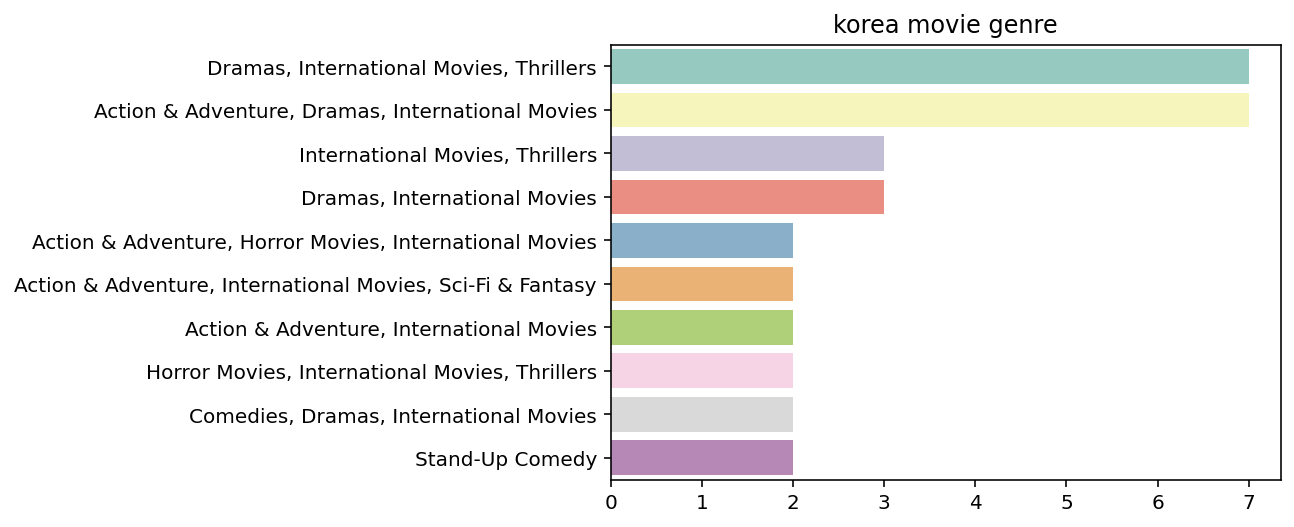

In [193]:
sns.barplot(y = k_movie.index,x=k_movie.values, palette="Set3")
plt.title("korea movie genre")
plt.show()

> 전체 영화 장르 : 드라마, 다큐, 코미디 등 높음

> 한국 영화 장르 : 드라마, 스릴러, 액션장르

## (생략)크롤링 데이터 활용

#### 어떤 국가가 퀄리티 좋은 영화를 만들까?

In [163]:
Top_movie.tail(2)

,title,points,countries,days
174,Bombshell,181,2,14
175,Man on a Ledge,174,4,13


In [164]:
Top_tv.tail(2)

,title,points,countries,days
150,Beauty and the Baker,"1,638",18,28
151,Zero Chill,"1,631",49,20


In [165]:
net_flix.tail(2)

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description
8805,s8806,Movie,Zoom,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,Older Kids,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."
8806,s8807,Movie,Zubaan,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,Teens,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...


In [166]:
len(Top_movie), len(Top_tv), len(net_flix)

(176, 152, 7305)